## Imports

In [2]:
import pandas as pd
import numpy as np
import random
import sklearn
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

## Sample the dataset to 10.000 lines

In [3]:
data_full = pd.read_csv('/home/guillaume/code/GGIML/vivadata-student/data/quora/train.csv.zip')

In [4]:
data_full.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [5]:
index_1 = data_full[data_full.target == 1].index

In [6]:
index_0 = data_full[data_full.target == 0].index

In [7]:
rand_1 = random.choices(index_1, k=5000)

In [8]:
rand_0 = random.choices(index_0, k=5000)

In [9]:
rand_0.extend(rand_1)

In [10]:
rand = np.array(rand_0)

In [11]:
rand[0]

124653

In [12]:
data = data_full.iloc[rand,:].reset_index(drop=True)

In [13]:
data.target.value_counts()

1    5000
0    5000
Name: target, dtype: int64

## EDA

In [14]:
data

,qid,question_text,target
0,1866113b124d00b940ed,Is it weird to masturbate using leggings/tight...,0
1,f03ca35ed49438e2d104,What is a integrated circuit timing chip?,0
2,9b9b971ecc57e2c9c16b,What is the integrity of the atomic orbital mo...,0
3,3873c6f93202fe2a947d,Is Khaftar's government in Libya justified in ...,0
4,f5015913aeb56996fd9f,What happens if you inject saline to a paralys...,0
...,...,...,...
9995,01231d607bb0a9e02379,How do you bend over and suck your own asshole?,1
9996,c4cc9eba9e17cd4941f5,How big is Dick Cheney's dick?,1
9997,718f0b22d0e969e94de6,Since everyone is complaining about police bru...,1
9998,3f58915988ad5641bf71,"As a gay person, what would be classified as p...",1


In [15]:
data.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

In [16]:
X = data.question_text

In [17]:
y = data.target

In [18]:
X.head(10)

0    Is it weird to masturbate using leggings/tight...
1            What is a integrated circuit timing chip?
2    What is the integrity of the atomic orbital mo...
3    Is Khaftar's government in Libya justified in ...
4    What happens if you inject saline to a paralys...
5           Does Trump believe in anything particular?
6    Why angle in game programming libraries usuall...
7    Do different foods taste better or worse at di...
8    When is someone important enough to be assassi...
9    How can I make homemande strawberry Hershey's ...
Name: question_text, dtype: object

## Text preprocessing

In [19]:
def get_wordnet_pos(pos_tag):
    output = np.asarray(pos_tag)
    for i in range(len(pos_tag)):
        if pos_tag[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pos_tag[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pos_tag[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
    return output

In [20]:
stop = stopwords.words('english')

In [21]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    pos_tags = nltk.pos_tag(tokens)
    tags = get_wordnet_pos(pos_tags)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(tokens[i], tags[i,1]) for i in range(len(tokens))]
    tokens = [t for t in tokens if t.isalpha() and t not in stop]
    return tokens

In [22]:
X_tk = X.apply(preprocess)

In [23]:
X_tk

0                  [weird, masturbate, use, stuff, sheet]
1                       [integrated, circuit, time, chip]
2                     [integrity, atomic, orbital, model]
3       [khaftar, government, libya, justify, cut, tie...
4               [happen, inject, saline, paralysed, hand]
                              ...                        
9995                                [bend, suck, asshole]
9996                            [big, dick, cheney, dick]
9997    [since, everyone, complain, police, brutality,...
9998      [gay, person, would, classify, premarital, sex]
9999    [much, america, israel, pay, guatemala, move, ...
Name: question_text, Length: 10000, dtype: object

## Sentiment analysis using TextBlob

In [24]:
from textblob import TextBlob

In [25]:
pol = np.array([TextBlob(x).sentiment.polarity for x in X])

In [26]:
subj = np.array([TextBlob(x).sentiment.subjectivity for x in X])

In [27]:
X_sentiment = pd.concat([X, pd.Series(pol, name='pol'), pd.Series(subj, name='subj')], axis = 1)

In [28]:
X_sentiment

,question_text,pol,subj
0,Is it weird to masturbate using leggings/tight...,-0.500000,1.000000
1,What is a integrated circuit timing chip?,0.000000,0.000000
2,What is the integrity of the atomic orbital mo...,0.000000,0.000000
3,Is Khaftar's government in Libya justified in ...,-0.100000,0.900000
4,What happens if you inject saline to a paralys...,0.000000,0.000000
...,...,...,...
9995,How do you bend over and suck your own asshole?,0.600000,1.000000
9996,How big is Dick Cheney's dick?,0.000000,0.100000
9997,Since everyone is complaining about police bru...,0.000000,0.000000
9998,"As a gay person, what would be classified as p...",0.416667,0.583333


In [29]:
X_sentiment.loc[(X_sentiment.pol <= 0.1) & (X_sentiment.subj >= 0.2),'sentiment'] = 1

In [30]:
X_sentiment.loc[(X_sentiment.pol > 0.1) & (X_sentiment.subj < 0.2),'sentiment'] = 0

In [31]:
(X_sentiment.sentiment == data.target).mean()

0.1837

## Word embedding (Glove)

In [32]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = []
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.append(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

In [33]:
words, word_to_vec_map = read_glove_vecs('/home/guillaume/code/GGIML/vivadata-student/data/quora/glove.6B.100d.txt')

In [34]:
word_to_vec_map

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [35]:
word_to_vec_map['difference']

array([ 0.23939  ,  0.64866  ,  0.64029  ,  0.59731  , -0.57069  ,
       -0.034481 ,  0.44231  , -0.39     , -0.25012  , -0.079481 ,
        0.1235   , -0.3098   , -0.22829  , -0.11238  ,  0.51555  ,
       -0.11811  , -0.65808  ,  0.2114   ,  0.16304  ,  0.36534  ,
        0.14231  , -0.0090299, -0.55039  , -0.20697  ,  0.080964 ,
       -0.3697   ,  0.2787   , -0.49157  , -0.1274   , -0.82568  ,
       -0.14165  ,  0.51621  ,  0.11311  , -0.30496  ,  0.22368  ,
       -0.12757  ,  0.0544   ,  0.71317  , -0.033935 , -0.26217  ,
        0.12878  , -0.36912  ,  0.03692  , -0.24024  , -0.82736  ,
       -0.13003  ,  0.46716  , -0.21663  , -0.93034  , -0.56656  ,
        0.73258  , -0.26062  ,  0.0047906,  1.0184   ,  0.2207   ,
       -1.8839   ,  0.35817  , -0.37361  ,  1.0114   ,  0.10976  ,
       -0.22822  ,  0.0079406, -0.63252  , -0.043958 ,  0.82144  ,
        0.43737  ,  0.097812 , -0.092006 ,  0.10427  ,  0.20588  ,
       -0.12203  ,  0.21231  ,  0.59581  ,  0.0077957,  0.7680

In [36]:
X_tk

0                  [weird, masturbate, use, stuff, sheet]
1                       [integrated, circuit, time, chip]
2                     [integrity, atomic, orbital, model]
3       [khaftar, government, libya, justify, cut, tie...
4               [happen, inject, saline, paralysed, hand]
                              ...                        
9995                                [bend, suck, asshole]
9996                            [big, dick, cheney, dick]
9997    [since, everyone, complain, police, brutality,...
9998      [gay, person, would, classify, premarital, sex]
9999    [much, america, israel, pay, guatemala, move, ...
Name: question_text, Length: 10000, dtype: object

In [37]:
X_wemb_inter = X_tk.apply(lambda x: [word_to_vec_map[t] for t in x if t in words])
X_wemb = X_wemb_inter.apply(lambda x: sum(x))

In [38]:
X_wemb = X_wemb.apply(pd.Series)

In [39]:
X_wemb.isna().sum()

0     0
1     8
2     8
3     8
4     8
     ..
95    8
96    8
97    8
98    8
99    8
Length: 100, dtype: int64

In [40]:
data_ready = pd.concat([X_wemb, y], axis = 1)

In [41]:
data_ready

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,-1.143910,1.445900,0.690670,-1.537091,-1.705104,2.532270,-0.266369,0.016370,-0.159365,1.367409,...,-0.399181,0.057291,-2.273580,0.808050,-1.420643,-1.260630,-1.512210,2.076480,1.901323,0
1,-0.086150,-0.006175,0.241370,0.551260,-0.028850,-1.146010,0.689510,0.619620,-0.629160,0.331705,...,1.218520,-1.281440,1.144977,-0.261410,0.439319,2.058490,-2.058578,3.277140,-0.452967,0
2,0.287426,1.472370,2.086960,1.477076,-1.651675,-2.739240,0.176570,1.341700,-0.864381,5.216000,...,1.826135,0.239143,1.482110,0.721080,0.061581,-0.448644,-2.448970,1.506955,0.598932,0
3,0.252488,0.351651,1.272848,0.499340,0.636688,-1.911509,-3.044962,2.856733,-0.217207,1.681417,...,-1.402211,-1.604290,-2.464720,-3.543600,-0.429190,0.571375,-0.563544,1.836533,-1.430947,0
4,-0.953434,0.954030,0.310206,0.607270,-1.045890,2.436960,-0.016831,1.847936,1.885463,-1.131348,...,-0.064481,-1.146279,0.452027,0.320890,1.838229,1.027243,-0.116401,1.174871,1.516785,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.538366,-0.282000,1.712300,-1.711870,-0.913220,0.967690,-0.873178,1.112920,0.835080,-0.607300,...,0.004790,-0.768350,-1.424450,0.283510,-1.230331,-0.013330,-0.787958,0.380330,1.016019,1
9996,-1.288811,-0.156690,2.061260,-2.575070,0.048216,-1.746020,2.419670,0.274553,-0.781835,-3.178030,...,0.554296,1.191610,1.297810,-1.058798,0.486711,-1.587470,1.614182,0.958980,-0.769710,1
9997,-0.112094,0.208290,1.954260,-0.718756,-3.281700,4.429268,-5.361545,3.984582,3.537061,1.462155,...,-4.686900,-3.632590,-1.026540,-4.952760,0.797939,-1.341456,0.780604,4.134964,2.501114,1
9998,3.386251,1.843892,0.435237,0.488232,-2.990707,3.713390,-0.833870,0.392770,2.315865,1.307862,...,-1.204585,0.611100,-2.161336,0.640406,-0.339547,-1.470806,-1.087220,0.321694,-0.341300,1


In [42]:
data_ready.dropna(axis = 0, inplace=True)

In [43]:
X_wemb = data_ready.drop('target', axis=1)

In [46]:
y_wemb = data_ready.target

## Train-test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_wemb, y_wemb, test_size=.2, stratify=y_wemb, random_state=42)

## Run the classification model

In [48]:
X_train.shape

(7993, 100)

In [49]:
logr = LogisticRegression(random_state=42, max_iter=500)

In [50]:
logr.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [51]:
test = pd.concat([X_test, y_test], axis=1)

In [68]:
test_O = test[test.target == 0]

In [69]:
test_1 = test[test.target == 1]

In [72]:
test_1 = test_1.iloc[:20, :]

In [73]:
test_sample = pd.concat([test_O, test_1], axis=0)

In [75]:
test_sample.target.value_counts()

0    999
1     20
Name: target, dtype: int64

In [76]:
X_test = test_sample.drop('target', axis=1)

In [77]:
y_test = test_sample.target

In [78]:
y_pred = logr.predict(X_test)

In [79]:
y_pred_train = logr.predict(X_train)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91       999
           1       0.10      0.90      0.18        20

    accuracy                           0.84      1019
   macro avg       0.55      0.87      0.55      1019
weighted avg       0.98      0.84      0.90      1019



In [81]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      3996
           1       0.84      0.82      0.83      3997

    accuracy                           0.83      7993
   macro avg       0.83      0.83      0.83      7993
weighted avg       0.83      0.83      0.83      7993



In [82]:
from sklearn.manifold import TSNE

In [83]:
tsne = TSNE(n_components=2)

In [84]:
X_vis = tsne.fit_transform(X_wemb)

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

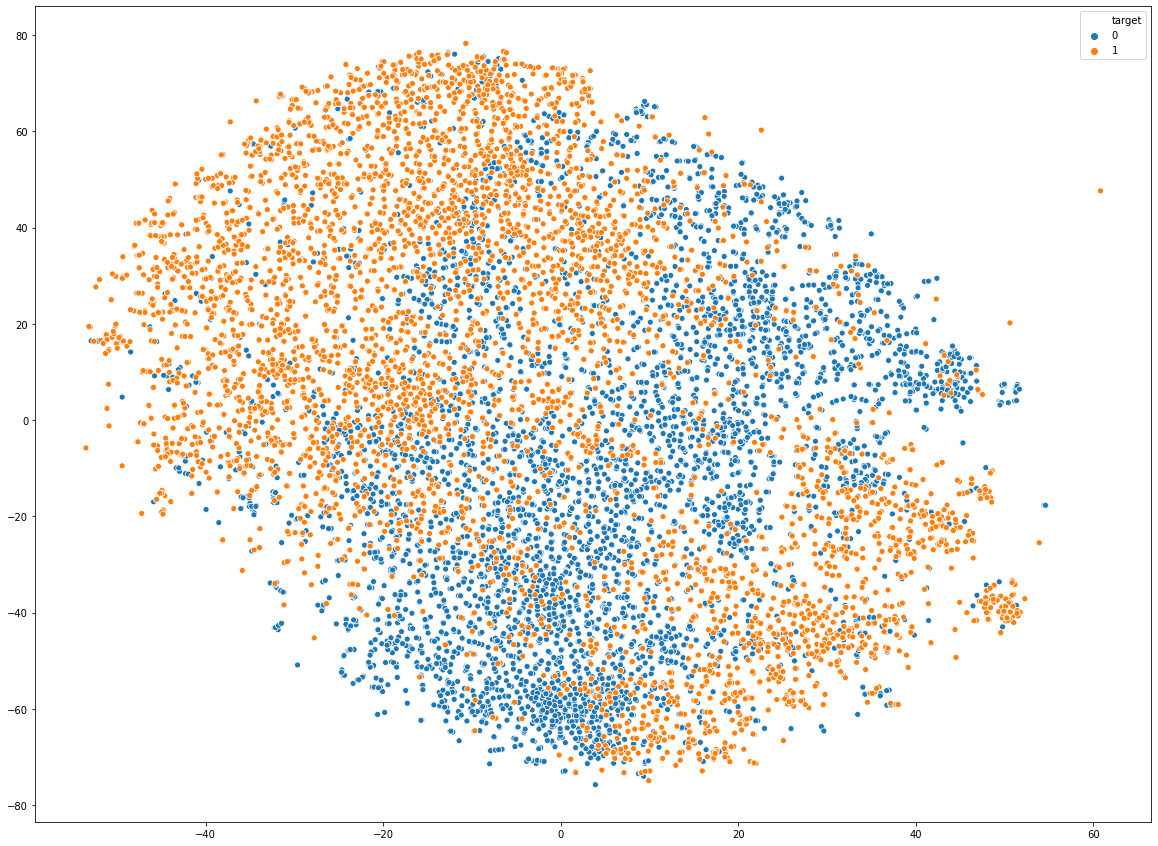

In [87]:
plt.figure(figsize=(20,15))
sns.scatterplot(X_vis[:,0], X_vis[:,1], hue=y_wemb)
plt.show()

## Optimization (text preprocessing, model hyperparameters,...)

### Let's try with a TF-IDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tk, y, test_size=.2, stratify=y, random_state=42)

In [54]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x)

In [55]:
tfidf_train = vectorizer.fit_transform(X_train_tfidf).toarray()

In [56]:
tfidf_test = vectorizer.transform(X_test_tfidf).toarray()

In [57]:
logr_tfidf = LogisticRegression(random_state=42)

In [58]:
logr_tfidf.fit(tfidf_train, y_train)

LogisticRegression(random_state=42)

In [59]:
y_pred_tfidf = logr_tfidf.predict(tfidf_test)

In [60]:
y_pred_train_tfidf = logr_tfidf.predict(tfidf_train)

In [61]:
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.84      0.81      0.82      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [62]:
print(classification_report(y_train, y_pred_train_tfidf))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4000
           1       0.92      0.89      0.91      4000

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000



In [63]:
tfidf_train.shape

(8000, 10584)

In [64]:
from sklearn.decomposition import PCA

In [65]:
pca = PCA(n_components=0.999, random_state=42)

In [ ]:
tfidf_train_red = pca.fit_transform(tfidf_train)

## Optimize ++: see published kernels

## Try to identify the most recurrent topics in toxic questions